<a href="https://colab.research.google.com/github/SaeedShadkam/Gaussian-Mixture-Support-Vector-Machines-GMSVM/blob/main/Bayesian_Vector_Autoregression_(BVAR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Conditional Forecasting Scenario Generation**

In order to deal with Vector autoregression (VAR) models parameterization, Bayesian techniques are often used, imposing structure through prior knowledge on model coefficients. There is much discussion about the optimal choice of the degree of informativity implied by these priors and can be approached by hierarchical modeling. BVAR, a R package dedicated to estimating Bayesian VAR models with prior hierarchical selection, is extensively used in this code. It incorporates features and options that allow a wide range of research problems to be solved, while maintaining an easy-to-use interface.



# Prerequisites

Loading "rpy2.ipython" module will let users to use %%R command to run R codes in a cell or %R for a single line

In [ ]:
%%capture
%load_ext rpy2.ipython
%load_ext google.colab.data_table

In [ ]:
%%capture
!pip install plotly -U
!pip install kaleido

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import time
import sys
import scipy.cluster.hierarchy as sch
from pprint import pprint

import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
pd.options.plotting.backend = "plotly"

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Download this file and upload it to colab
# https://cdn.plot.ly/plotly-latest.min.js
# 2. Uncomment this line of code and run the cell
#plotly.offline.init_notebook_mode(connected=True)
# 3.run the whole code, the plot will go away
# 4. download the ipynb file and upload it to colab
# 5. run this line of code
# !jupyter nbconvert — to html BVAR.ipynb
# 6. run this code when done to go back to normal
# plotly.io.renderers.default = 'colab'

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

In [ ]:
%%capture
from functools import partial
from rpy2.ipython import html
import rpy2.ipython.html
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.ipython.ggplot import image_png
rpy2.ipython.html.init_printing()
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")

For conditional forecasting of macro variables, we need to install both BVAR and coda packages from R.

In [ ]:
%%capture
%%R
install.packages("BVAR")
install.packages("coda")
#install.packages("TSdist")

In [ ]:
%%capture
%%R
library("coda")
library("parallel")
library("BVAR")
library("repr")
#library("TSdist")

In [ ]:
#TSdist = importr('TSdist')
#base = importr('base')

# Functions


## Conversion

%Rpush and %Rpull are two command to move objects from R to Python or vice versa

In [ ]:
def convert_BVAR_chain(bvar_chain):
  converted = {}
  for i in range(len(bvar_chain)):
    converted[i] = convert_R2Py_dict(bvar_chain[i])
  return converted

In [ ]:
# convert rpy2 objects to python dictionary, Rpull have to be done first
def convert_R2Py_dict(r_list):
    converted = {}
    for name in r_list.names:
        val = r_list.rx(str(name))[0]
        if isinstance(val, np.ndarray):
            converted[name] = val
        elif isinstance(val, ro.vectors.DataFrame):
            converted[name] = pandas2ri.rpy2py_dataframe(val)
        elif isinstance(val, ro.vectors.FloatMatrix):
            converted[name] = pd.DataFrame(np.array(val))
            if hasattr(val, 'rownames') and not isinstance(val.rownames, rpy2.rinterface.NULLType):
              converted[name].index = val.rownames
            if hasattr(val, 'rownames') and not isinstance(val.colnames, rpy2.rinterface.NULLType):
              converted[name].columns = val.colnames
        elif isinstance(val, ro.vectors.FloatArray):
            converted[name] = np.array(val)
        elif isinstance(val, ro.vectors.ListVector):
            converted[name] = convert_R2Py_dict(val)
        elif isinstance(val, ro.vectors.FloatVector) or isinstance(val, ro.vectors.StrVector):
            if len(val) == 1:
                converted[name] = val[0]
            else:
                converted[name] = list(val)
        else: # single value
            converted[name] = val
    return converted

In [ ]:
# convert rpy2 data.frame to pandas
def convert_RPy2_to_Py(r_obj):
  with localconverter(ro.default_converter + pandas2ri.converter):
    py_obj = ro.conversion.rpy2py(r_obj)
  return py_obj
# convert pandas to rpy2 data.frame
def convert_Py_to_RPy2(py_obj):
  with localconverter(ro.default_converter + pandas2ri.converter):
    rpy_obj = ro.conversion.py2rpy(py_obj)
  return rpy_obj

## Others

In [ ]:
def progressBar(value, end_value, start_time, bar_length=20):
    percent = float(value) / end_value
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    remaining = int(((time.time()-start_time)/value)*(end_value-value)/60)
    sys.stdout.write("\rCompleted: [{0}] {1}% - {2} minutes remaining.".format(arrow + spaces, int(round(percent * 100)), remaining))
    sys.stdout.flush()

In [ ]:
def correlDist(corr):
  # A distance matrix based on correlation, where 0<=d[i,j]<=1
  # This is a proper distance metric
  dist=((1-corr)/2.)**.5 # distance matrix
  #dist=np.sqrt(np.clip((1.0 - cor) / 2., a_min=0.0, a_max=1.0))
  #np.fill_diagonal(dist, val=0.0)
  return dist

def cluster_corrmat(corrmat, nb_clusters=10, dist=None):
  if dist is None:
    dist = correlDist(corrmat)
  dim = dist.shape[0]
  tri_a, tri_b = np.triu_indices(dim, k=1)
  Z = sch.linkage(dist.values[tri_a, tri_b], method='ward')
  permutation = sch.leaves_list(sch.optimal_leaf_ordering(Z, dist.values[tri_a, tri_b]))
  ordered_corr = corrmat.values[permutation, :][:, permutation]
  permuted_cols = corrmat.columns[permutation]
  ordered_corr = pd.DataFrame(ordered_corr, index=permuted_cols, columns=permuted_cols)

  ordered_dist = dist[permuted_cols].reindex(permuted_cols)
  dim = ordered_dist.shape[0]
  tri_a, tri_b = np.triu_indices(dim, k=1)
  ordered_Z = sch.linkage(ordered_dist.values[tri_a, tri_b], method='ward')
  clustering_inds = sch.fcluster(ordered_Z, nb_clusters, criterion='maxclust')
  clusters = {i: [] for i in range(min(clustering_inds), max(clustering_inds) + 1)}
  for i, v in enumerate(clustering_inds):
    clusters[v].append(i)
  return ordered_corr, clusters

In [ ]:
def calculate_tsdist_R(rpy2_mat, distance="cdm"):
  df = convert_RPy2_to_Py(rpy2_mat)
  dist = TSdist.TSDatabaseDistances(base.as_matrix(base.t(rpy2_mat)), distance=distance)
  dist_temp = convert_RPy2_to_Py(dist)
  dim = df.shape[1]
  tri_a, tri_b = np.triu_indices(dim, k=1)
  dist = np.ndarray((dim, dim))
  dist[tri_a, tri_b] = dist_temp
  dist[tri_b, tri_a] = dist_temp
  np.fill_diagonal(dist, 0.5)
  dist_df = pd.DataFrame(dist, index=df.columns, columns=df.columns)
  return dist_df

def calculate_CDM_dist_Py(df):
  dist_df = pd.DataFrame(index=df.columns, columns=df.columns)
  dim = len(df.columns)
  t = time.time()
  for i in range(dim):
    for j in range(i, dim):
      temp_dist = convert_RPy2_to_Py(TSdist.CDMDistance(
          base.as_numeric(df.iloc[:,i].values.tolist()),
          base.as_numeric(df.iloc[:,j].values.tolist())))[0]
      dist_df.iloc[i,j] = temp_dist
      dist_df.iloc[j,i] = temp_dist
      progressBar(int(i*dim-i*(i-1)/2+j-i+1), int(dim*(dim+1)/2), t)
  return dist_df

In [ ]:
def print_clusters(corr_ordered, corr_clusters):
  for i, cluster in enumerate(corr_clusters):
      print('Cluster', i + 1)
      cluster_members = [corr_ordered.index[ind] for ind in corr_clusters[cluster]]
      print('Cluster size:', len(cluster_members))
      pprint(cluster_members, width=120, compact=True)
      print()

## Plotting

In [ ]:
def plot_fred_dataset(des):
  groups = np.unique(des.group)
  columns = ['id', 'tcode', 'fred', 'description', 'gsi:description']
  first_group = 'Consumption and Orders'
  def get_des_group(group_name):
      temp_group = des[des.group==group_name]
      cell_list = []
      for col in columns:
        cell_list.append(temp_group[col])
      return cell_list
  fig = go.Figure(data=[go.Table(
      header=dict(values=columns,
                  fill_color='paleturquoise',
                  align='left'),
      cells=dict(values=get_des_group(first_group),
                fill_color='lavender',
                align='left'))
  ])
  updatemenus_buttons = [{'method': 'update',
                  'label': groups[i],
                  'args': [{'cells': dict(
                      values=get_des_group(groups[i]),
                      fill_color='lavender',
                      align='left')
                      }]} for i in range(len(groups))]
  updatemenus = [{'buttons': updatemenus_buttons,
                  'direction': 'down',
                  'showactive': True,
                  'x': 0,
                  'xanchor': "left",
                  'y': 1.1,
                  'yanchor': "top"}]
  fig.update_layout(
      yaxis_title='Variable',
      title='FRED-MD Dataset Description',
      hovermode="x",
      updatemenus=updatemenus
  )
  fig.show()

In [ ]:
def plot_corrmat(ordered_corr, clusters):
  fig = px.imshow(ordered_corr)
  for cluster_id, cluster in clusters.items():
    xmin, xmax = min(cluster), max(cluster)
    ymin, ymax = min(cluster), max(cluster)
    fig.add_shape(type="rect", x0=xmin-0.5, y0=ymin-0.5, x1=xmax+0.5, y1=ymax+0.5,
                  line=dict(color="RoyalBlue"))

  config = dict({'scrollZoom': True})
  fig.show(config=config)
  return fig

In [ ]:
def plot_dendrogram(corrmat):
  tri_a, tri_b = np.triu_indices(corrmat.shape[0], k=1)
  fig = ff.create_dendrogram(
      corrmat, orientation='bottom', labels=corrmat.columns,
      distfun=lambda x: correlDist(x),
      linkagefun=lambda x: sch.linkage(x.values[tri_a, tri_b], method='ward'),
  )
  fig.update_layout(width=1000, height=600)
  config = dict({'scrollZoom': True})
  fig.show(config=config)
  fig.update_xaxes(
        tickangle = 90,
        title_text = "Stocks")
  return fig

In [ ]:
def plot_bvar_predict(main_data, quants, variables, conf_bands, t_back = 16, var_start_index=0):
  horizon = quants.shape[1]
  nband = conf_bands.shape[0]
  color_number = np.array(list(reversed(range(1,nband+1))))*int(255/(nband+1))
  color_strings = ['rgb({},{},255,0.1)'.format(c,c) for c in color_number]
  def get_y_list(var_index):
    y_list = []
    y_list.append(np.append(main_data.iloc[-t_back:,[var_index]].values, quants[nband,0,var_index]))
    for i in range(2*nband+1):
      y_list.append(quants[i,:,var_index])
    return y_list
  y_list_start = get_y_list(var_start_index)
  #
  marker_size = 0
  marker_color = 'rgba(0, 0, 0, 0)'
  scatter_list = []
  scatter_list.append(
      go.Scatter(
          name='Observed value',
          x=list(range(t_back+1)),
          y=y_list_start[0],
          marker=dict(
              color='Black',
              size=10,
              line=dict(
                color='Black',
                width=0
              )),
          mode='lines',
          showlegend=False
      ),
  )
  scatter_list.append(
      go.Scatter(
          name='{}% Lower Bound'.format(conf_bands[0]*100),
          x=list(range(t_back,t_back+horizon)),
          y=y_list_start[1],
          marker=dict(
              color=marker_color,
              size=marker_size,
              line=dict(
                color='Blue',
                width=0
              )),
          mode='lines',
          showlegend=False
      ),
  )
  for i in range(1,nband):
    scatter_list.append(
      go.Scatter(
          name='{}% Lower Bound'.format(conf_bands[i]*100),
          x=list(range(t_back,t_back+horizon)),
          y=y_list_start[1+i],
          marker=dict(
              color=marker_color,
              size=marker_size,
              line=dict(
                color='Blue',
                width=0
              )),
          mode='lines',
          fillcolor=color_strings[i-1],
          fill='tonexty',
          showlegend=False
      ),
    )
  scatter_list.append(
      go.Scatter(
          name='Mean',
          x=list(range(t_back,t_back+horizon)),
          y=y_list_start[nband+1],
          marker=dict(
              color='Black',
              size=10,
              line=dict(
                color='Blue',
                width=0
              )),
          mode='lines',
          fillcolor=color_strings[nband-1],
          fill='tonexty',
          showlegend=False
      ),
  )
  for i in range(nband+1,2*nband+1):
    scatter_list.append(
      go.Scatter(
          name='{}% Upper Bound'.format(100 - conf_bands[2*nband-i]*100),
          x=list(range(t_back,t_back+horizon)),
          y=y_list_start[i+1],
          marker=dict(
              color=marker_color,
              size=marker_size,
              line=dict(
                color='Blue',
                width=0
              )),
          mode='lines',
          fillcolor=color_strings[2*nband-i],
          fill='tonexty',
          showlegend=False
      ),
    )

  fig = go.Figure(scatter_list)
  fig.add_vline(x=t_back, line_width=3, line_dash="dash", line_color="green")
  updatemenus_buttons = [{'method': 'update',
                'label': variables[i],
                'args': [{'y': get_y_list(i)}]}
                for i in range(len(variables))]
  updatemenus = [{'buttons': updatemenus_buttons,
                  'direction': 'down',
                  'showactive': True,
                  'x': 0,
                  'xanchor': "left",
                  'y': 1.1,
                  'yanchor': "top"}]
  fig.update_layout(
      yaxis_title='Variable',
      title='Forecasts for {} period horizon'.format(horizon),
      hovermode="x",
      updatemenus=updatemenus
  )
  fig.show()
  return fig

In [ ]:
def plot_bvar_irf(quants, variables, conf_bands):
  horizon = quants.shape[2]
  nband = conf_bands.shape[0]
  color_number = np.array(list(reversed(range(1,nband+1))))*int(255/(nband+1))
  color_strings = ['rgb({},{},{},0.3)'.format(c,c,c) for c in color_number]
  def get_y_list(var_index1, var_index2):
    y_list = []
    for i in range(2*nband+1):
      y_list.append(quants[i,var_index1,:,var_index2])
    return y_list
  y_list_start = get_y_list(0,1)
  #
  marker_size = 0
  marker_color = 'rgba(135, 206, 250, 0.1)'
  scatter_list = []
  scatter_list.append(
      go.Scatter(
          name='{}% Lower Bound'.format(conf_bands[0]*100),
          x=list(range(horizon)),
          y=y_list_start[0],
          marker=dict(
              color=marker_color,
              size=marker_size,
              line=dict(
                color='Blue',
                width=0
              )),
          mode='lines',
          showlegend=False
      ),
  )
  for i in range(1,nband):
    scatter_list.append(
      go.Scatter(
          name='{}% Lower Bound'.format(conf_bands[i]*100),
          x=list(range(horizon)),
          y=y_list_start[i],
          marker=dict(
              color=marker_color,
              size=marker_size,
              line=dict(
                color='Blue',
                width=0
              )),
          mode='lines',
          fillcolor=color_strings[i-1],
          fill='tonexty',
          showlegend=False
      ),
    )
  scatter_list.append(
      go.Scatter(
          name='Mean',
          x=list(range(horizon)),
          y=y_list_start[nband],
          marker=dict(
              color='Blue',
              size=20,
              line=dict(
                color='Blue',
                width=0
              )),
          mode='lines',
          fillcolor=color_strings[nband-1],
          fill='tonexty',
          showlegend=False
      ),
  )
  for i in range(nband+1,2*nband+1):
    scatter_list.append(
      go.Scatter(
          name='{}% Upper Bound'.format(100 - conf_bands[2*nband-i]*100),
          x=list(range(horizon)),
          y=y_list_start[i],
          marker=dict(
              color=marker_color,
              size=marker_size,
              line=dict(
                color='Blue',
                width=0
              )),
          mode='lines',
          fillcolor=color_strings[2*nband-i],
          fill='tonexty',
          showlegend=False
      ),
    )

  fig = go.Figure(scatter_list)
  updatemenus_buttons = [{'method': 'update',
                          'label': 'Shock {} on {}'.format(variables[i],variables[j]),
                          'args': [{'y': get_y_list(j, i)}]}
                         for i in range(len(variables)) for j in range(len(variables))]
  updatemenus = [{'buttons': updatemenus_buttons,
                  'direction': 'down',
                  'showactive': True,
                  'x': 0,
                  'xanchor': "left",
                  'y': 1.1,
                  'yanchor': "top"}]
  fig.update_layout(
      yaxis_title='Variable',
      title='Impluse Resplonse Function for {} period horizon'.format(horizon),
      hovermode="x",
      updatemenus=updatemenus
  )
  fig.show()

In [ ]:
def plot_bvar_residuals(res_py, vars_py):
  fig = go.Figure([
      go.Scatter(
          name='Lower Bound',
          y=res_py[:,0],
          marker=dict(
              color='LightSkyBlue',
              size=10,
              line=dict(
                  color='MediumPurple',
                  width=2
              )
          ),
          mode='markers',
          showlegend=False
      ),
  ])
  updatemenus_buttons = [{'method': 'update',
                'label': vars_py[i],
                'args': [{'y': [res_py[:,i]]}]}
                for i in range(len(vars_py))]
  updatemenus = [{'buttons': updatemenus_buttons,
                  'direction': 'down',
                  'showactive': True,}]
  fig.update_layout(
      yaxis_title='Variable',
      title='Residuals',
      hovermode="x",
      updatemenus=updatemenus
  )
  fig.show()

In [ ]:
def plot_trace(data_trace):
  fig = go.Figure([
        go.Scatter(
            name='Lower Bound',
            y=data_trace,
            marker=dict(
                color='LightSkyBlue',
                size=10,
                line=dict(
                    color='MediumPurple',
                    width=2
                )
            ),
            mode='lines',
            showlegend=False
        ),
    ])
  fig.show()

In [ ]:
def plot_density(hist_data, group_labels):
  # Create distplot with custom bin_size
  fig = ff.create_distplot(hist_data, group_labels, bin_size=[0.05])
  fig.show()

# Data Description

In [ ]:
des = pd.read_excel('/content/drive/MyDrive/FRED-MD - Description.xlsx')
plot_fred_dataset(des)

# Data Preparation

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/macro_inputs.xlsx', sheet_name='Updated Hist Data')
df.head()

Date  year  ...  Unemp_Rate_Canada  HHCounts_Can
0 1990-01-31  1990  ...           7.622711      9.740052
1 1990-02-28  1990  ...           7.646302      9.755183
2 1990-03-31  1990  ...           7.632242      9.772925
3 1990-04-30  1990  ...           7.614256      9.793073
4 1990-05-31  1990  ...           7.640709      9.813419

[5 rows x 13 columns]

**Data transformation and stationarity**

---

Econometric analysis often relies on data coming in a specific format, frequently requiring
transformation. The helper function fred_transform() facilitates this work step. It can be
used to apply common transformations, subset data to a rectangular format without missing
values, and automatically transform the included FRED-QD and FRED-MD datasets.


When estimating a VAR model in differences, implications on the priors need to be taken into
account. The sum-of-coefficients prior and the single-unit-root prior are no longer applicable.
For this example we only impose the Minnesota prior, which also needs to be adjusted slightly
to still carry the notion that variables follow a random walk.

**Code for Transformations:**
1. None
2. 1st-diff -->  $\Delta x_t$
3. 2nd-diff -->  $\Delta^2 x_t$
4. log -->  $\log x_t$
5. log-diff --> $\Delta \log x_t$
6. log-2nd-diff --> $\Delta^2 \log x_t$
7. pct-ch-diff --> $\Delta x_t/x_{t-1} - 1$



In [ ]:
%%R
# Access a subset of the fred_md dataset
# Transform it to be stationary
#x_us_variables <- c('RPI', 'W875RX1', 'CMRMTSPLx', 'RETAILx', 'INDPRO','IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'UMCSENTx', 'MZMSL', 'DTCTHFNM', 'INVEST')
x_us_variables <- colnames(fred_md)
exclude_list <- c("TWEXMMTH", "NONBORRES", "HWI", "AWHMAN", "VXOCLSx", "TOTRESNS", "CES0600000007")
x_us_variables <- x_us_variables[x_us_variables %in% exclude_list == FALSE]
x_us <- fred_md[, x_us_variables]
x_us_normal <- fred_transform(x_us, type = "fred_md")
#x_us_normal <- fred_transform(x_us, codes = c(4, 4, 4, 4, 4, 1))

# Access Canada's Macroeconomic data
tibble_ca <- readxl::read_excel('/content/drive/MyDrive/macro_inputs.xlsx', sheet = 'Updated Hist Data')
x_ca_variables <- c("Date", "cpi_Canada",	"HPI_Canada",	"Housing_Starts_Canada",	"Nominal_HH_Income_CA")
#x_ca_variables <- c("Date", "cpi_Canada",	"HPI_Canada",	"Housing_Starts_Canada",	"Nominal_HH_Income_CA", "Nominal_HH_Income_CA", "NonRes_Permit_Value_Canada", "Nominal_Wages_Salary_CA", "Real_GDP_Canada", "Real_Med_Family_Income_Canada", "Unemp_Rate_Canada", "HHCounts_Can")
x_ca <- tibble_ca[, x_ca_variables]
x_ca <- as.data.frame(x_ca)
rownames(x_ca) <- x_ca$Date
x_ca$Date <- NULL

#x_ca_normal <- fred_transform(x_ca, codes = c(5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5))
x_ca_normal <- fred_transform(x_ca, codes = c(5, 5, 5, 5))

In [ ]:
%Rpull x_us x_us_normal
x_us_df = convert_RPy2_to_Py(x_us)
x_us_normal_df = convert_RPy2_to_Py(x_us_normal)
x_us_normal_df.index = pd.to_datetime(x_us_normal_df.index)
x_us_normal_df.tail()

RPI   W875RX1  ...  DTCTHFNM    INVEST
2019-09-01  0.221334  0.201326  ... -0.571444  0.403723
2019-10-01 -0.064283 -0.113373  ...  0.404053 -1.399327
2019-11-01  0.376575  0.447783  ... -0.114506  0.642379
2019-12-01 -0.089432 -0.055069  ...  0.047230 -1.055734
2020-01-01  0.471625  0.275041  ... -0.124689  0.389172

[5 rows x 114 columns]

In [ ]:
x_us_normal_df.plot()

In [ ]:
%Rpull x_ca x_ca_normal
x_ca_df = convert_RPy2_to_Py(x_ca)
x_ca_normal_df = convert_RPy2_to_Py(x_ca_normal)
x_ca_normal_df.index = pd.to_datetime(x_ca_normal_df.index)
# IMPORTANT NOTE: the date for Canada's data is the last day of each month,
# however the date for the US's data is the first day of the month
x_ca_normal_df.index  += datetime.timedelta(days=1)
x_ca_normal_df.tail()

cpi_Canada  HPI_Canada  Housing_Starts_Canada  Nominal_HH_Income_CA
2020-03-01    0.235259    0.092166              -2.388614             -1.100849
2020-04-01    0.373004   -0.332716             -16.710951             -2.896259
2020-05-01   -0.374707   -0.610234             -29.339074             -3.696967
2020-06-01   -2.353978   -0.624352             -29.785983             -2.713444
2020-07-01   -4.957607   -0.441782              -7.019889             -0.449292

In [ ]:
x_ca_us_normal = pd.merge(x_ca_normal_df, x_us_normal_df, how='inner', left_index=True, right_index=True)
x_ca_us_normal.plot(title="Normalized Macroeconomic Data of US and Canada")

# Macro Factor Selection

In [ ]:
# Calculate distance with TSDist package
#dist_us = calculate_tsdist_R(x_us_normal)
#dist_us = calculate_CDM_dist_Py(x_us_normal_df.iloc[100:200, :])
#dist_ca = calculate_tsdist_R(x_ca_normal)

In [ ]:
ca_corr_matrix = x_ca_normal_df.iloc[100:200, :].corr()
us_corr_matrix = x_us_normal_df.iloc[100:200, :].corr()

In [ ]:
# If the distance is not provided, distance is measured based on the correlation
us_corr_ordered, us_corr_clusters = cluster_corrmat(us_corr_matrix, nb_clusters=30, dist=None)

In [ ]:
fig = plot_corrmat(us_corr_ordered, us_corr_clusters)

In [ ]:
fig = plot_dendrogram(us_corr_ordered)

In [ ]:
print_clusters(us_corr_ordered, us_corr_clusters)

Cluster 1
Cluster size: 12
['USFIRE', 'HOUSTMW', 'PERMITMW', 'HOUSTW', 'HOUST', 'PERMIT', 'PERMITW', 'PERMITS', 'HOUSTS', 'HOUSTNE', 'PERMITNE',
 'USCONS']

Cluster 2
Cluster size: 3
['AAAFFM', 'T10YFFM', 'T5YFFM']

Cluster 3
Cluster size: 8
['TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'CP3Mx', 'FEDFUNDS', 'TB3MS', 'TB6MS', 'GS1']

Cluster 4
Cluster size: 2
['GS10', 'GS5']

Cluster 5
Cluster size: 2
['EXJPUSx', 'EXSZUSx']

Cluster 6
Cluster size: 4
['USTRADE', 'USTPU', 'PAYEMS', 'SRVPRD']

Cluster 7
Cluster size: 8
['BUSINVx', 'USWTRADE', 'USGOOD', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'AMDMUOx', 'CES1021000001']

Cluster 8
Cluster size: 3
['IPCONGD', 'IPNCONGD', 'IPB51222S']

Cluster 9
Cluster size: 4
['IPFUELS', 'IPNMAT', 'IPMAT', 'INDPRO']

Cluster 10
Cluster size: 6
['IPBUSEQ', 'IPMANSICS', 'CUMFNS', 'IPFPNSS', 'IPFINAL', 'IPDMAT']

Cluster 11
Cluster size: 3
['EXUSUKx', 'ACOGNO', 'IPDCONGD']

Cluster 12
Cluster size: 2
['AWOTMAN', 'HWIURATIO']

Cluster 13
Cluster size: 2
['AMDMNOx', 'ANDENOx']



# Prior setup and further configuration

**sum-of-coefficients prior settings:**

---



This prior was first proposed by Doan et al. (1984). It basically adds n synthetic observations, one for every variable (n), that implies a no-change-state to the beginning of the model.

The dummy observations are constructed by the below equations:
\begin{equation}
\begin{aligned}
y_{n \times n}^{+} &=\operatorname{diag}\left(\frac{\bar{y}_{0}}{\mu}\right) \\
x^{+} &=\left[\underset{n \times 1}{0}, y^{+}, \ldots, y^{+}\right]
\end{aligned}
\end{equation}

where ${\bar{y}_{0}}$ is the average value of first p observations and $y_{n \times n}^{+}$ is the matrix of synthetic observations.The hyperparameter μ controls the variance of these prior beliefs: as μ → ∞, the prior becomes uninformative, while μ → 0 implies the presence of a unit root in each equation and rules out cointegration. Then these observations are added to the first of the data matrixes.

Bearing the original BVAR equation in mind:
\begin{equation}
y_{t}=X_{t} \beta+\varepsilon_{t}
\end{equation}
 This prior is equivalent to, in each equation, getting the sum of coefficients on own lags for each variable to 1 and getting the sum of coefficients on other variables’ lags close to 0.

To add this prior one might use bv_dummy or bv_soc.

---



**Reference**: Giannone, D., Lenza, M. and Primiceri, G.E., 2015. Prior selection for vector autoregressions. Review of Economics and Statistics, 97(2), pp.436-451.

In [ ]:
%%R

add_soc <- function(Y, lags, par) {
  soc <- if(lags == 1) {diag(Y[1, ]) / par}
  else {diag(colMeans(Y[1:lags, ])) / par}

Y_soc <- soc
X_soc <- cbind(rep(0, ncol(Y)), matrix(rep(soc, lags), nrow = ncol(Y)))
return(list("Y" = Y_soc, "X" = X_soc))
}
soc <- bv_dummy(mode = 1, sd = 1, min = 0.0001, max = 50, fun = add_soc)

**Single-unit-root prior settings:**

---

This prior first proposed by (Sims 1993; Sims and Zha 1998), allows for cointegration relationships to the data. It attempts to get variables closer to their unconditional mean or toward the presence of at least one unit root by adding dummy observations to the data in the form of:

\begin{equation}
\begin{aligned}
{\boldsymbol{y}}^{++}_{1 \times M} &=\frac{\overline{\boldsymbol{y}}}{\delta} \\
 \boldsymbol{x}^{++}_{1 \times (1+Mp)} &=\left[\frac{1}{\delta}, \boldsymbol{y}^{++}, \ldots, \boldsymbol{y}^{++}\right] \\
\end{aligned}
\end{equation}

Similar to the sum-of-coefficinet prior, $\overline{y}$ is the mean of first p lagged observations, while the $\delta$ is the variables that controls the tightness of the prior.

This prior might be added to bv_priors by employing the bv_dummy or bv_sur functions.

---

**Reference:** Kuschnig, N. and Vashold, L., 2019. BVAR: Bayesian Vector Autoregressions with Hierarchical Prior Selection in R.






In [ ]:
%%R

add_sur <- function(Y, lags, par) {
  sur <- if(lags == 1) {Y[1, ] / par}
  else {colMeans(Y[1:lags, ]) / par}
  Y_sur <- sur
  X_sur <- c(1 / par, rep(sur, lags))
  return(list("Y" = Y_sur, "X" = X_sur))
  }

sur <- bv_dummy(mode = 1, sd = 1, min = 0.0001, max = 50, fun = add_sur)

**Litterman/Minnesota prior Settings:**

---



Litterman/Minnesota prior is a specific gaussian prior of VAR parameters. As a result, the model shrinks into a multivariate random walk model, and is often used as a benchmark model. It follows to main steps:


> 1- In each equation, it sets the prior mean of the first lagged dependent variable to 1, and all other variables to 0.

> 2- While it assumes the variance of the constant parameters is infinite, it fits a diagonal matrix with form of :

\begin{equation}
v_{i j, l}=\left\{\begin{array}{ll}
(\lambda / l)^{2} & \text { if } i=j, \\
\left(\lambda \theta \sigma_{i} / l \sigma_{j}\right)^{2} & \text { if } i \neq j,
\end{array}\right.
\end{equation}

to each $ij^{th}$ element of $A_l$. In the above equation, $\lambda$ is the prior standard deviation of $a_{i i, 1}$ and $\theta$ which is a value between 0, 1 determines the relative tightness of he prior variance in the other lags in a given equation compared to the own lags. $\sigma_{i}^2$ reperesnts the $i^{th}$ diagonal element of $\sum_i$.

**Litterman/Minnesota prior hyperparameters are:**



*   $\lambda$: Controls the tightness of the prior.
*   $\alpha$: Cuases variance decay wih increasing lag order.
*   $\psi$:  controls the prior’s standard deviation on lags of variables other than the dependent.
*   var: Prior variance of constants.
*   b: Prior means of all variables, default value is 1, should be changed to 0 for growth models.


The first three hyperparameters are given by functions bv_lambda, bv_alpha, and bv_psi respectively.Here are examples of applying these fnctions:


---



**Reference**: Kilian, L. and Lütkepohl, H., 2017. Structural vector autoregressive analysis. Cambridge University Press.


In [ ]:
%%R

# Adjust alpha and the Minnesota prior variance.
bv_mn(alpha = bv_alpha(mode = 0.5, sd = 1, min = 1e-12, max = 10), var = 1e6)
# Optionally use a vector as shorthand
bv_mn(alpha = c(0.5, 1, 1e-12, 10), var = 1e6)
# Only adjust lambda's standard deviation
bv_mn(lambda = bv_lambda(sd = 2))
# Provide prior modes for psi (for a VAR with three variables)
bv_mn(psi = bv_psi(mode = c(0.7, 0.3, 0.9)))

Minnesota prior:
lambda:
Shape / Scale: 1.64 / 0.312
Mode / Bounds: 0.2 / [1e-04, 5]
alpha:
Shape / Scale: 65.985 / 0.031
Mode / Bounds: 2 / [1, 3]
psi:
Shape / Scale: 0.004 / 0.004
#1 Mode / Bounds: 0.7 / [0.007, 70]
#2 Mode / Bounds: 0.3 / [0.003, 30]
#3 Mode / Bounds: 0.9 / [0.009, 90]

Variance of the constant term: 1e+07 


**Example of employing single-unit-root + minnesota prior by bv_priors**

In [ ]:
%%R

# Extend the hyperparameters to the full Minnesota prior
bv_priors(hyper = c("lambda", "alpha", "psi"))
# Alternatively
# bv_priors("full")
# Add a dummy prior via `bv_dummy()`
# Re-create the single-unit-root prior
add_sur <- function(Y, lags, par) {
    sur <- if(lags == 1) {Y[1, ] / par}
    else {colMeans(Y[1:lags, ]) / par}
    Y_sur <- sur
    X_sur <- c(1 / par, rep(sur, lags))
    return(list("Y" = Y_sur, "X" = X_sur))
    }

sur <- bv_dummy(mode = 1, sd = 1, min = 0.0001, max = 50, fun = add_sur)
# Add the new prior
bv_priors(hyper = "auto", sur = sur)

Object with prior settings for `bvar()`.
Hyperparameters: lambda, sur

Minnesota prior:
lambda:
Shape / Scale: 1.64 / 0.312
	Mode / Bounds: 0.2 / [1e-04, 5]
alpha:
Shape / Scale: 65.985 / 0.031
	Mode / Bounds: 2 / [1, 3]
psi:
Shape / Scale: 0.004 / 0.004
	 Mode / Bounds: retrieved automatically

Variance of the constant term: 1e+07 

Dummy prior(s):
sur:
Shape / Scale: 2.618 / 0.618
	Mode / Bounds: 1 / [1e-04, 50]


In [ ]:
%%R
## 1
mn <- bv_minnesota(lambda = bv_lambda(mode = 0.2, sd = 0.4, min = 0.0001, max = 5),
                   alpha = bv_alpha(mode = 2), var = 1e07)

soc <- bv_soc(mode = 1, sd = 1, min = 1e-04, max = 50)
sur <- bv_sur(mode = 1, sd = 1, min = 1e-04, max = 50)

priors <- bv_priors(hyper = "auto", mn = mn, soc = soc, sur = sur)

mh <- bv_metropolis(scale_hess = c(0.05, 0.0001, 0.0001),
                    adjust_acc = TRUE, acc_lower = 0.25, acc_upper = 0.45)

**Metropolis-Hastings settings:**


---

This algorithm, which is specific type of MCMC, uses a conditional distribution named $\eta\left(\boldsymbol{\theta}^{+} \mid \boldsymbol{\theta}^{(i-1)}\right)$. Given ${\theta}^{(i-1)}$, ${\theta}^{(i)}$ is estimated by employing the conditional distribution.
This Algorithm consists of three main steps:

> 1- According to the $\eta\left(\boldsymbol{\theta}^{+} \mid \boldsymbol{\theta}^{(i-1)}\right)$ distribution a prospect ${\theta}^{+}$ is drawn.



> 2- Employing below equation, the Acceptance probability is calculated:

\begin{equation}
\begin{aligned}
\min \left\{\frac{g\left(\boldsymbol{\theta}^{+} \mid \mathbf{y}\right) / \eta\left(\boldsymbol{\theta}^{+} \mid \boldsymbol{\theta}^{(i-1)}\right)}{g\left(\boldsymbol{\theta}^{(i-1)} \mid \mathbf{y}\right) / \eta\left(\boldsymbol{\theta}^{(i-1)} \mid \boldsymbol{\theta}^{+}\right)}, 1\right\}
\end{aligned}
\end{equation}



> 3- A uniform random number between [0,1] is drawn. If acceptance probability > random number, then ${\theta}^{(i)} = {\theta}^{+}$, otherwise ${\theta}^{(i)} = {\theta}^{(i-1)}$


In this package, to implement Metropolis-Hastings two identical functions namely bv_metropolis and bv_mh are provided. The input arguments are as follow:



*   scale_hess: Scaling parameter, determining the range of hyperparameter draws. Should be calibrated so a reasonable acceptance rate is reached.(It allows scaling the inverse Hessian, which is used as VCOV matrix of the Gaussian proposal distribution of the hierarchically treated hyperparameters.)
*   adjust_acc: True/False variable deciding whether to further scale the variability of parameter draws during the burn-in phase
*   adjust_burn: How much of burn-in phase be used to scale parameter variability.
*   acc_lower: Should be set if adjust_acc is True, lower bound of target acceptance rate
*   acc_upper: Should be set if adjust_acc is True, upper bound of target acceptance rate
*   acc_change: Percent change applied to the Hessian matrix for tuning acceptance rate. Required if adjust_acc is set to TRUE.






In [ ]:
%%R
# Increase the scaling parameter
bv_mh(scale_hess = 1)
# Turn on automatic scaling of the acceptance rate to [20%, 40%]
bv_mh(adjust_acc = TRUE, acc_lower = 0.2, acc_upper = 0.4)
# Increase the rate of automatic scaling
bv_mh(adjust_acc = TRUE, acc_lower = 0.2, acc_upper = 0.4, acc_change = 0.1)
# Use only 50% of the burn-in phase to adjust scaling
bv_mh(adjust_acc = TRUE, adjust_burn = 0.5)

Object with settings for the Metropolis-Hastings step in `bvar()`.
Scaling parameter: 0.01
Automatic acceptance adjustment: TRUE
Target acceptance: [0.25, 0.45]
Change applied: 0.01


**Final BVAR prior and Metropolis-Hasting Settings:**


---

bv_priors gets an argument named hyper determining which parameters to be treated as hyperparameters. It can be set to 'auto'/'full' for an automatic/full subset, or it can specify the parameter names like 'lambda' or 'alpha'

In [ ]:
%%R


mn2 <- bv_minnesota(var = 1e07, b=0)


priors_app <- bv_priors(hyper = "auto", mn = mn)
mh <- bv_metropolis(scale_hess = 1, adjust_acc = TRUE, acc_lower = 0.25, acc_upper = 0.45, acc_change = 0.01)
run_ca <- bvar(x_ca_normal, lags = 5, n_draw = 15000, n_burn = 5000, n_thin = 1,  priors = priors_app, mh = mh, verbose = TRUE)

Optimisation concluded.
Posterior marginal likelihood: 1042.934
Hyperparameters: lambda = 5
  |======================================================================| 100%
Finished MCMC after 22.13 secs.


In [ ]:
%%R


mn <- bv_minnesota(var = 1e07, b=0)

soc <- bv_soc(mode = 0.001, sd = 1, min = 1e-05, max = 50)
sur <- bv_sur(mode = 0.001, sd = 1, min = 1e-05, max = 50)

priors_app <- bv_priors(hyper = "full", mn = mn, soc = soc, sur = sur)
mh <- bv_metropolis(scale_hess = 1, adjust_acc = TRUE, acc_lower = 0.25, acc_upper = 0.45, acc_change = 0.01)
run_ca <- bvar(x_ca_normal, lags = 5, n_draw = 10000, n_burn = 5000, n_thin = 1,  priors = priors_app, mh = mh, verbose = TRUE)

Optimisation concluded.
Posterior marginal likelihood: 1670.239
Hyperparameters: lambda = 4.97482; alpha = 1.09455; psi1 = 0.00846; psi2 = 0.00317; psi3 = 1.189; psi4 = 0.01495; soc = 1e-05; sur = 1e-05
  |======================================================================| 100%
Finished MCMC after 14.51 secs.


# Estimation of the model

In [ ]:
%%R
## Canada
run_ca <- bvar(x_ca_normal, lags = 5, n_draw = 15000, n_burn = 5000, n_thin = 1,  priors = priors_app, mh = mh, verbose = TRUE)

Optimisation concluded.
Posterior marginal likelihood: 1670.239
Hyperparameters: lambda = 4.97482; alpha = 1.09455; psi1 = 0.00846; psi2 = 0.00317; psi3 = 1.189; psi4 = 0.01495; soc = 1e-05; sur = 1e-05
  |======================================================================| 100%
Finished MCMC after 19.38 secs.


Bayesian simulation relies heavily on the convergence of samplers, particularly so for hierarchical models. As demonstrated in Section 4.4, BVAR includes functionality to assess convergence visually. Many more tools are available through the interface to coda, which
specializes in output assessment for Markov chain Monte Carlo (MCMC) simulations. To access the interface we call the as.mcmc() method on the VAR model from Appendix A. The method works similarly to plot(), allowing users to subset hyperparameters or VAR coefficients with vars, vars_response, and vars_impulse. These are then converted to a
’mcmc’ object, which supports thorough analysis of convergence behavior. This includes the diagnostic statistics of Geweke (1992), which can be calculated with geweke.diag().


The value of the diagnostic statistic constitutes a standard z score and indicates proper withinchain convergence of the hyperparameter λ. Still, one may also be interested in the behavior across chains. A suitable diagnostic to assess between-chain convergence was proposed by
Gelman and Rubin (1992) and is implemented in coda as gelman.diag(). The need for multiple chains makes parallelization attractive, which is supported by the wrapper function par_bvar(). The wrapper uses parLapply() from the parallel package (R Core Team 2020) to run instances of bvar() on multiple threads. The output is a ’bvar_chains’ object, i.e., a
’list’ of ’bvar’ objects that is supported by covergence-related methods. We can visualize the separate runs for different hyperparameters or the ML, which can be specified via the
vars argument, with the plot() method (see Figure 8). We can also transform it for use with coda, by calling as.mcmc(), which now yields a ’mcmc_list’ object. This object is passed on to gelman.diag(), in order to compute a diagnostic statistics for between-chain
convergence.

In [ ]:
%%R
run_mcmc <- as.mcmc(run_ca, vars = "lambda")
geweke.diag(run_mcmc)


Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

lambda 
   Inf 



**par_bvar:**
Wrapper for bvar to simplify parallel computation via parLapply. Make sure to properly start and
stop the provided cluster.

In [ ]:
%%R
n_cores <- 2
cl <- makeCluster(n_cores)
runs <- par_bvar(cl = cl, data = x_ca_normal, lags = 5, n_draw = 15000, n_burn = 5000, n_thin = 1,
                 priors = priors_app, mh = bv_mh(scale_hess = 0.5, adjust_acc = TRUE))
stopCluster(cl)
runs_mcmc <- as.mcmc(runs, vars = "lambda")
gelman.diag(runs_mcmc, autoburnin = FALSE)

Potential scale reduction factors:

       Point est. Upper C.I.
lambda       10.4         24



# Analyzing outputs

## Plotting the BVAR Object

png can be used to save the R plot into a file, dev.off() is required after plotting is done.

In [ ]:
#png(file="plot.png", width=1600, height=800)
#dev.off()
#img = mpimg.imread('plot.png')
#fig, ax = plt.subplots(figsize=(16, 8))
#plt.imshow(img)
#plt.show()

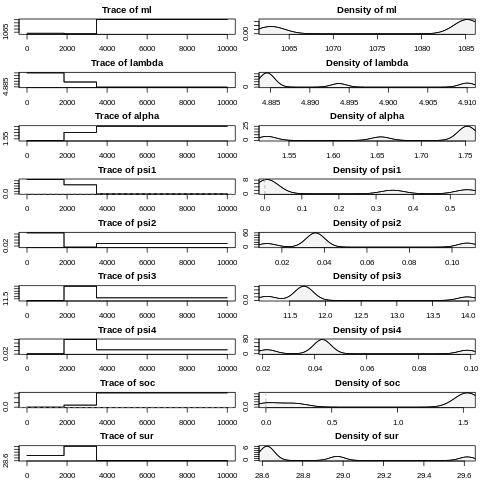

In [ ]:
%%R
## Canada
# Check convergence via trace and density plots
plot(run_ca)

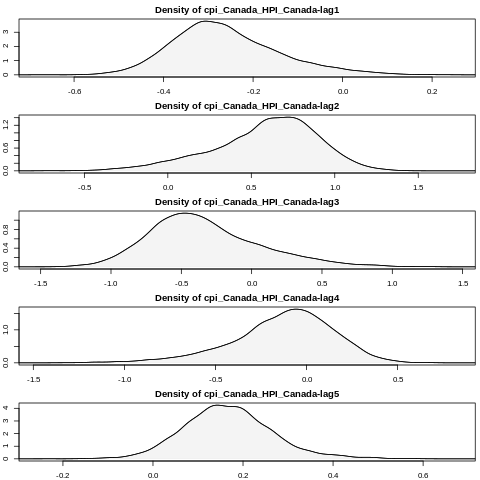

In [ ]:
%%R
## Canada
plot(run_ca, type = "dens", vars_response = "cpi_Canada", vars_impulse = "HPI_Canada")

## Plotting the residuals

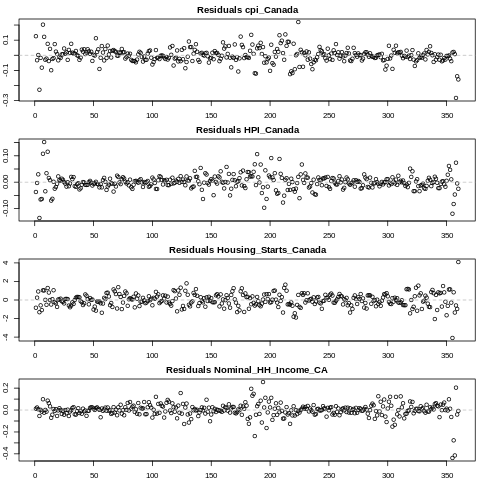

In [ ]:
%%R
## Canada
fitted(run_ca, type = "mean")
plot(residuals(run_ca, type = "mean"), vars = c("cpi_Canada",	"HPI_Canada",	"Housing_Starts_Canada",	"Nominal_HH_Income_CA"))

## Plotting the Impulse Response Functions

Retrieves / calculates impulse response functions (IRFs) and/or forecast error variance decompositions
(FEVDs) for Bayesian VARs generated via bvar. If the object is already present and no
settings are supplied it is simply retrieved, otherwise it will be calculated ex-post. Note that FEVDs
require the presence / calculation of IRFs. To store the results you may want to assign the output
using the setter function (irf(x) <-irf(x)). May also be used to update confidence bands.

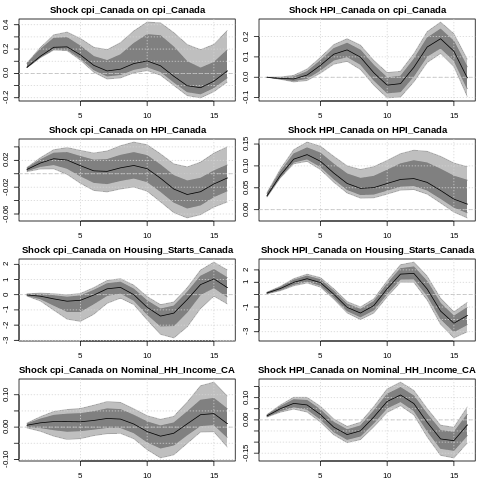

In [ ]:
%%R
## Canada
opt_irf <- bv_irf(horizon = 16, identification = TRUE)
irf(run_ca) <- irf(run_ca, opt_irf, conf_bands = c(0.05, 0.16))
#irf(run_ca) <- irf(run_ca, horizon = 20, identification = TRUE)
plot(irf(run_ca), area = TRUE, vars_impulse = c("cpi_Canada",	"HPI_Canada"))

## Plotting the Unconditional Forecasting

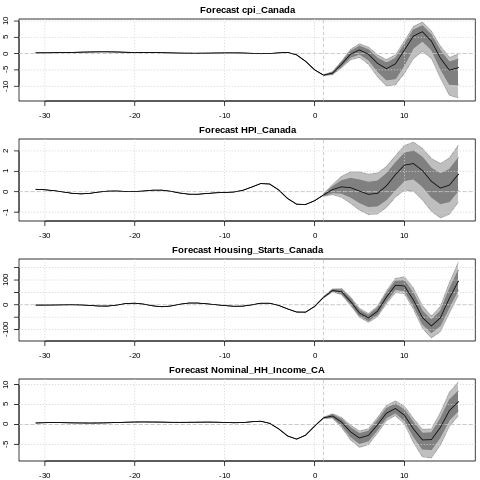

In [ ]:
%%R
## Canada
# Plot forecasts
predict(run_ca) <- predict(run_ca, horizon = 16, conf_bands = c(0.05, 0.16))
plot(predict(run_ca), area = TRUE, t_back = 32)

## Plotting the Conditional Forecasting

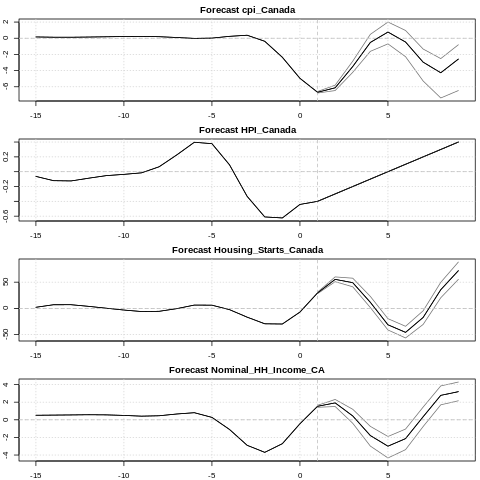

In [ ]:
%%R
## Canada
path <- c(-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4)
predict(run_ca) <- predict(run_ca, horizon = 9, cond_path = path, cond_var = "HPI_Canada")
plot(predict(run_ca), t_back = 16)

# Convertion to Python

rpy2 can be used to convert R objects to Python objects

In [ ]:
%%R
print(run_ca)

Bayesian VAR consisting of 360 observations, 4 variables and 5 lags.
Time spent calculating: 19.38 secs
Hyperparameters: lambda, alpha, psi, soc, sur 
Hyperparameter values after optimisation: 4.97482, 1.09455, 0.00846, 0.00317, 1.189, 0.01495, 1e-05, 1e-05
Iterations (burnt / thinning): 15000 (5000 / 1)
Accepted draws (rate): 2 (0)


In [ ]:
%Rpull run_ca
bvar_py = convert_RPy2_to_Py(run_ca)
bvar_result_dict = convert_R2Py_dict(bvar_py)

In [ ]:
bvar_result_dict.keys()

dict_keys(['beta', 'sigma', 'hyper', 'ml', 'optim', 'priors', 'call', 'variables', 'explanatories', 'meta', 'irf', 'fcast'])

In [ ]:
%%R
print(runs)

[[1]]
Bayesian VAR consisting of 360 observations, 4 variables and 5 lags.
Time spent calculating: 39.35 secs
Hyperparameters: lambda, alpha, psi, soc, sur 
Hyperparameter values after optimisation: 4.97482, 1.09455, 0.00846, 0.00317, 1.189, 0.01495, 1e-05, 1e-05
Iterations (burnt / thinning): 15000 (5000 / 1)
Accepted draws (rate): 3 (0)

[[2]]
Bayesian VAR consisting of 360 observations, 4 variables and 5 lags.
Time spent calculating: 40.06 secs
Hyperparameters: lambda, alpha, psi, soc, sur 
Hyperparameter values after optimisation: 4.97482, 1.09455, 0.00846, 0.00317, 1.189, 0.01495, 1e-05, 1e-05
Iterations (burnt / thinning): 15000 (5000 / 1)
Accepted draws (rate): 3 (0)

attr(,"class")
[1] "bvar_chains"


In [ ]:
%Rpull runs
bvar_py = convert_RPy2_to_Py(runs)
bvar_result_dict = convert_BVAR_chain(bvar_py)

In [ ]:
bvar_result_dict.keys()

dict_keys([0, 1])

# Plotting with Plotly


## Plot Conditional and Unconditional Forecastings

In [ ]:
%%R
#run_ca_predict <- predict(run_ca, horizon = 16, conf_bands = c(0.05, 0.16))
conf_bands = c(0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40)
path <- c(-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4)
run_ca_predict <- predict(run_ca, horizon = 16, cond_path = path, cond_var = "HPI_Canada", conf_bands = conf_bands)

In [ ]:
%Rpull run_ca_predict conf_bands
run_ca_predict_py = convert_RPy2_to_Py(run_ca_predict)
conf_bands_py = convert_RPy2_to_Py(conf_bands)
run_ca_predict_result_dict = convert_R2Py_dict(run_ca_predict_py)
run_ca_predict_result_dict.keys()
fcast_ca = run_ca_predict_result_dict['fcast']
data_ca = run_ca_predict_result_dict['data']
quants_ca = run_ca_predict_result_dict['quants']
variables_ca = run_ca_predict_result_dict['variables']
print(fcast_ca.shape, data_ca.shape, quants_ca.shape)

In [ ]:
%%R
#run_ca_predict <- predict(run_ca, horizon = 16, conf_bands = c(0.05, 0.16))
conf_bands = c(0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40)
path <- c(-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4)
run_ca_predict <- predict(run_ca, horizon = 16, cond_path = path, cond_var = "HPI_Canada", conf_bands = conf_bands)

In [ ]:
%Rpull run_ca_predict conf_bands
run_ca_predict_py = convert_RPy2_to_Py(run_ca_predict)
conf_bands_py = convert_RPy2_to_Py(conf_bands)
run_ca_predict_result_dict = convert_R2Py_dict(run_ca_predict_py)
run_ca_predict_result_dict.keys()

dict_keys(['fcast', 'setup', 'variables', 'data', 'quants'])

In [ ]:
fcast_ca = run_ca_predict_result_dict['fcast']
data_ca = run_ca_predict_result_dict['data']
quants_ca = run_ca_predict_result_dict['quants']
variables_ca = run_ca_predict_result_dict['variables']
print(fcast_ca.shape, data_ca.shape, quants_ca.shape)

(10000, 16, 4) (360, 4) (17, 16, 4)


In [ ]:
data_ca_new = data_ca.append(pd.DataFrame(quants_ca[3,:,:], columns=variables_ca))
data_ca_new.reset_index(inplace=True, drop=True)
pltly = data_ca_new.iloc[-32:,:].plot()
pltly.add_vline(x=360, line_width=3, line_dash="dash", line_color="green")

In [ ]:
fig = plot_bvar_predict(data_ca, quants_ca, variables_ca, conf_bands_py, t_back=16)

In [ ]:
#fig.write_html('bvar_predict.html', include_plotlyjs='cdn')

## Plot Impluse Resplonse Functions


In [ ]:
%%R
conf_bands = c(0.05, 0.10, 0.25)
opt_irf <- bv_irf(horizon = 16, identification = TRUE)
run_ca_irf <- irf(run_ca, opt_irf, conf_bands = conf_bands)

In [ ]:
%Rpull run_ca_irf conf_bands
run_ca_irf_py = convert_RPy2_to_Py(run_ca_irf)
conf_bands_py = convert_RPy2_to_Py(conf_bands)
run_ca_irf_result_dict = convert_R2Py_dict(run_ca_irf_py)
run_ca_irf_result_dict.keys()

dict_keys(['irf', 'fevd', 'setup', 'variables', 'quants'])

In [ ]:
irf_quants_ca = run_ca_irf_result_dict['quants']
irf_variables_ca = run_ca_irf_result_dict['variables']
print(irf_quants_ca.shape)

(7, 4, 16, 4)


In [ ]:
plot_bvar_irf(irf_quants_ca, irf_variables_ca, conf_bands_py)

## Plot residuals

In [ ]:
%%R
run_ca_res <- residuals(run_ca, type = "mean")

In [ ]:
%Rpull run_ca_res x_ca_variables
run_ca_res_py = convert_RPy2_to_Py(run_ca_res)
vars_py = convert_RPy2_to_Py(x_ca_variables)[1:]
vars_py

<rpy2.robjects.vectors.StrVector object at 0x7f05022e6140> [RTYPES.STRSXP]
R classes: ('character',)
['cpi_Canada', 'HPI_Canada', 'Housing_S..., 'Nominal_H...]

In [ ]:
plot_bvar_residuals(run_ca_res_py, vars_py)

## Plot BVAR Density and Trace

In [ ]:
%Rpull run_ca
bvar_py = convert_RPy2_to_Py(run_ca)
bvar_result_dict = convert_R2Py_dict(bvar_py)
bvar_result_dict.keys()

dict_keys(['beta', 'sigma', 'hyper', 'ml', 'optim', 'priors', 'call', 'variables', 'explanatories', 'meta', 'irf', 'fcast'])

In [ ]:
ml_ca = bvar_result_dict['ml']
plot_trace(ml_ca)

In [ ]:
plot_density([ml_ca], ['ml'])